In [259]:
import numpy as np
from skimage.feature import corner_harris, peak_local_max
import matplotlib.pyplot as plt
from skimage import io, color
from scipy.spatial.distance import cdist
from skimage.filters import gaussian
from sklearn.neighbors import KDTree
from matplotlib.patches import ConnectionPatch
import cv2

In [173]:
def get_harris_corners(im, edge_discard=20, threshold=0.2):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method='eps', sigma=2)
    h[h < threshold] = 0
    coords = peak_local_max(h, min_distance=1)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    return h, coords


def dist2(x, c):
    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert(dimx == dimc, 'Data dimension does not match dimension of centers')

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)

<>:33: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:33: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/var/folders/4s/66z0r0jx3_v86ztl39l2c07m0000gn/T/ipykernel_83997/3789224660.py:33: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(dimx == dimc, 'Data dimension does not match dimension of centers')


In [50]:
image_path = "./images/kitchen1.jpg"
image = io.imread(image_path)

bw_image = color.rgb2gray(image)
harris_h, harris_coords = get_harris_corners(bw_image, 20, 0.1)

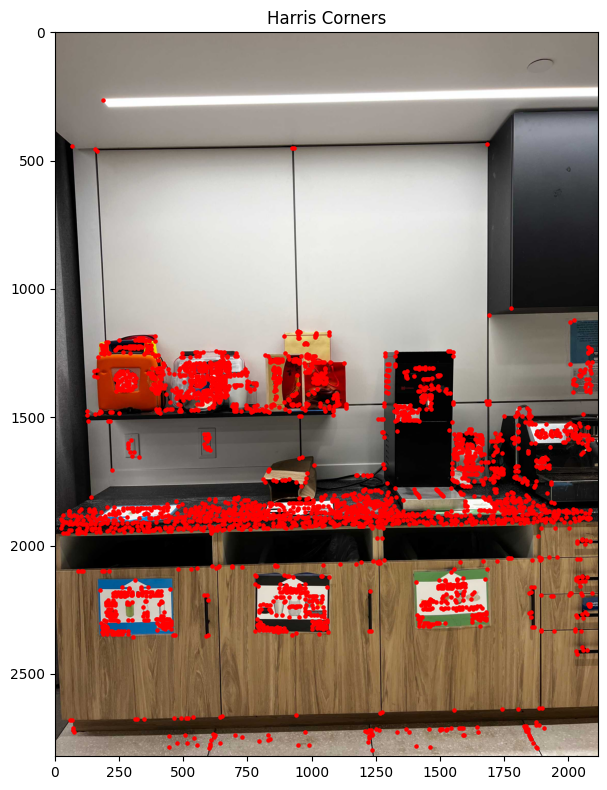

In [52]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(image)
ax.scatter(harris_coords[1], harris_coords[0], c='r', s=5, marker='o')

ax.set_title('Harris Corners')

plt.tight_layout()
plt.savefig("./partb/harris_corners.jpg", bbox_inches='tight') 
plt.show()

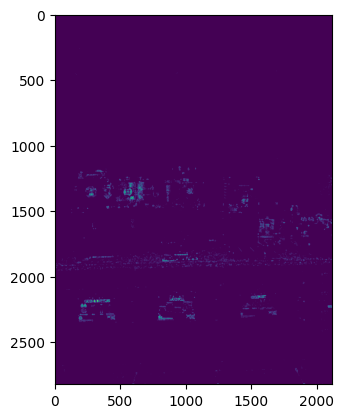

In [55]:
plt.imshow(harris_h)
plt.imsave("./partb/harris_matrix.jpg", harris_h)

In [59]:
def anms(h, coords, thres=20):
    coords = coords.T 
    
    valid_mask = (coords[:, 0] < h.shape[0]) & (coords[:, 1] < h.shape[1])
    coords = coords[valid_mask]

    keypoints = np.column_stack((coords, h[coords[:, 0], coords[:, 1]]))
    coords = keypoints[:, :2]
    responses = keypoints[:, 2]
    
    distances = dist2(coords, coords)
    
    radii = np.full(len(keypoints), np.inf)
    
    for i in range(len(keypoints)):
        for j in range(len(keypoints)):
            if responses[j] > responses[i]:
                radii[i] = min(radii[i], distances[i, j])

    indices = np.argsort(radii)[::-1]
    
    selected_indices = indices[:thres]
    coords = coords[selected_indices]
    
    return h, coords.T

[2.90331944 2.71636817 2.707375   ... 0.1001854  0.1001731  0.10009622]
[inf inf inf ... inf inf inf]
Number of keypoints after filtering: 3022
Responses: [2.90331944 2.71636817 2.707375   ... 0.1001854  0.1001731  0.10009622]
Radii: 4.0 inf 3022


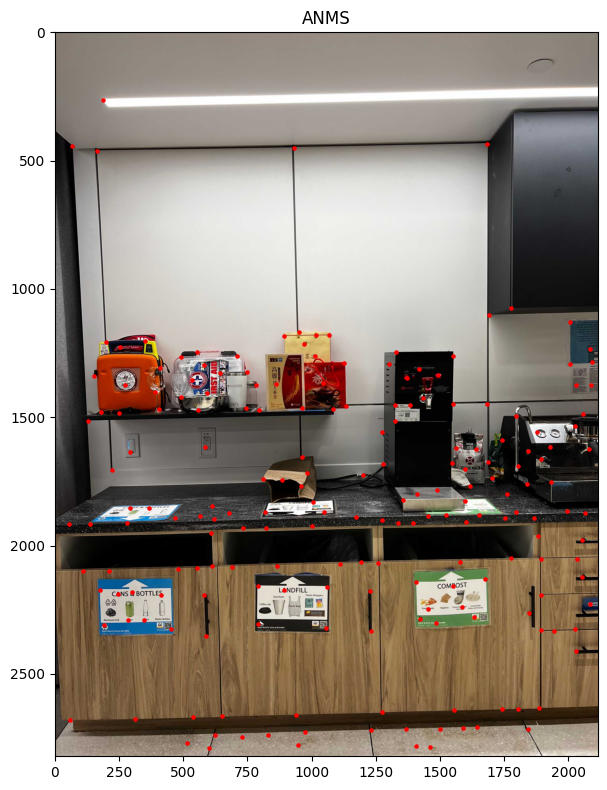

In [257]:
h, coords = anms(harris_h, harris_coords, 200)
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(image)
ax.scatter(coords[1], coords[0], c='r', s=5, marker='o')

ax.set_title('ANMS')

plt.tight_layout()
plt.savefig("./partb/anms.jpg", bbox_inches='tight') 
plt.show()

In [181]:
def extract_and_normalize_features(image, coords, patch_radius=20, feature_spacing=5, sigma=5):
    blurred_image = gaussian(image, sigma=(sigma, sigma), channel_axis=2)
    
    patch_size = 2 * patch_radius + 1
    feature_size = patch_size // feature_spacing + 1
    
    features = []
    
    for y, x in coords.T:
        y, x = int(y), int(x)
        
        if (y - patch_radius >= 0 and y + patch_radius < image.shape[0] and 
            x - patch_radius >= 0 and x + patch_radius < image.shape[1]):
            patch = blurred_image[y-patch_radius:y+patch_radius+1, x-patch_radius:x+patch_radius+1, :]
            
            sampled_patch = patch[::feature_spacing, ::feature_spacing, :]
            
            feature = sampled_patch.reshape(-1)
            
            for c in range(3):
                channel_data = feature[c::3]
                feature[c::3] = (channel_data - np.mean(channel_data)) / (np.std(channel_data) + 1e-7)
            
            features.append(feature)
    
    return np.array(features)

def display(features, num_features = 5):
    fig, axes = plt.subplots(1, num_features, figsize=(15, 3))
    feature_size = int(np.sqrt(len(features[0]) // 3))
    
    for i in range(num_features):
        feature = features[i].reshape(feature_size, feature_size, 3)
        
        feature = (feature - feature.min()) / (feature.max() - feature.min())
        
        axes[i].imshow(feature)
        axes[i].set_title(f'Feature {i+1}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig("./partb/patches.jpg", bbox_inches='tight')
    plt.show()

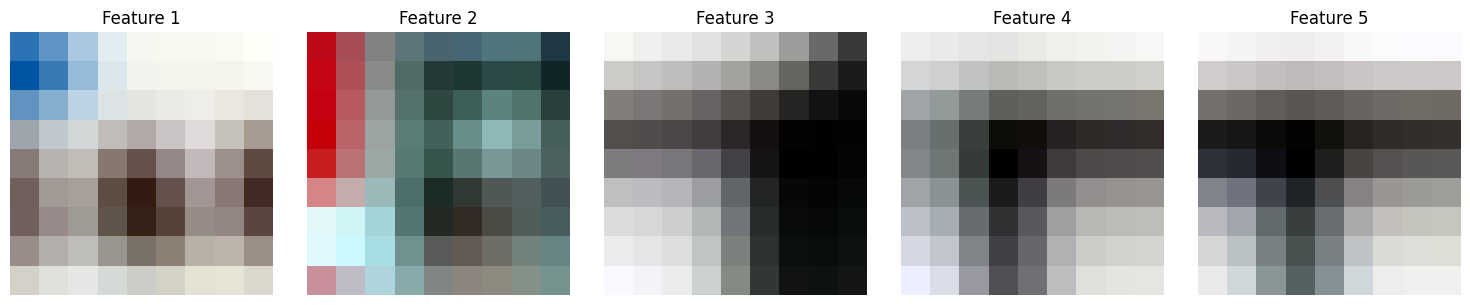

In [182]:
features_1 = extract_and_normalize_features(image, coords)
display(features_1)

[3.30736232 3.23362301 3.18740643 ... 0.10017731 0.10011113 0.1000206 ]
[inf inf inf ... inf inf inf]
Number of keypoints after filtering: 3710
Responses: [3.30736232 3.23362301 3.18740643 ... 0.10017731 0.10011113 0.1000206 ]
Radii: 4.0 inf 3710


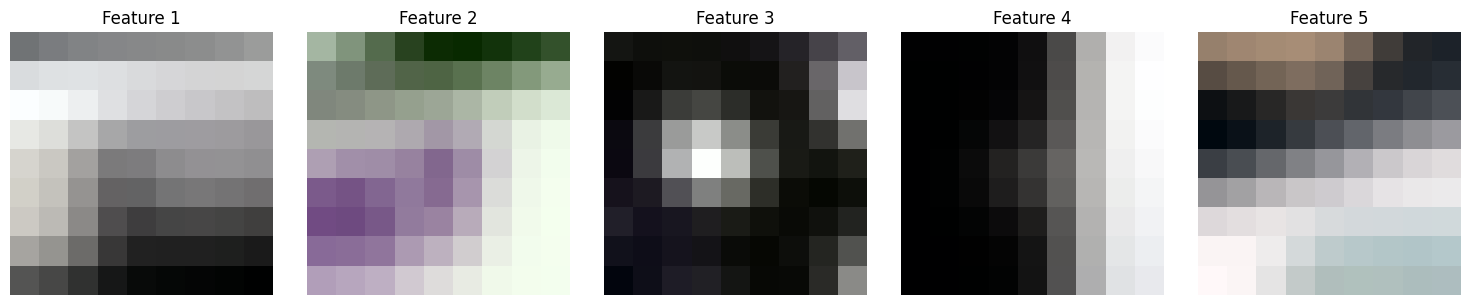

In [234]:
def getFeatures(imgpath):
    image = io.imread(imgpath)
    bw_image = color.rgb2gray(image)
    harris_h, harris_coords = get_harris_corners(bw_image, 20, 0.1)
    anms_h, anms_coords = anms(harris_h, harris_coords, 200)
    features = extract_and_normalize_features(image, anms_coords)
    return anms_coords, features
    
image_path = "./images/kitchen2.jpg"
image_2 = io.imread(image_path)
coords_2, features_2, features_2_coords = getFeatures(image_path)
display(features_2)

In [204]:
def match_finder(features1, features2, ratio_threshold=0.75):
    kdtree2 = KDTree(features2)
    matches = []
    
    for i, feature in enumerate(features1):
        distances, indices = kdtree2.query([feature], k=2)
        
        dist1, dist2 = distances[0]
        idx1, idx2 = indices[0]
        
        # Ratio test
        if dist1 / dist2 < ratio_threshold:
            matches.append((i, idx1))
    
    return np.array(matches)

# Now let's use this function
matched_features = match_finder(features_1, features_2)

In [247]:
matched_coords_1 = coords[:, matched_features[:, 0]]
matched_coords_2 = coords_2[:, matched_features[:, 1]]

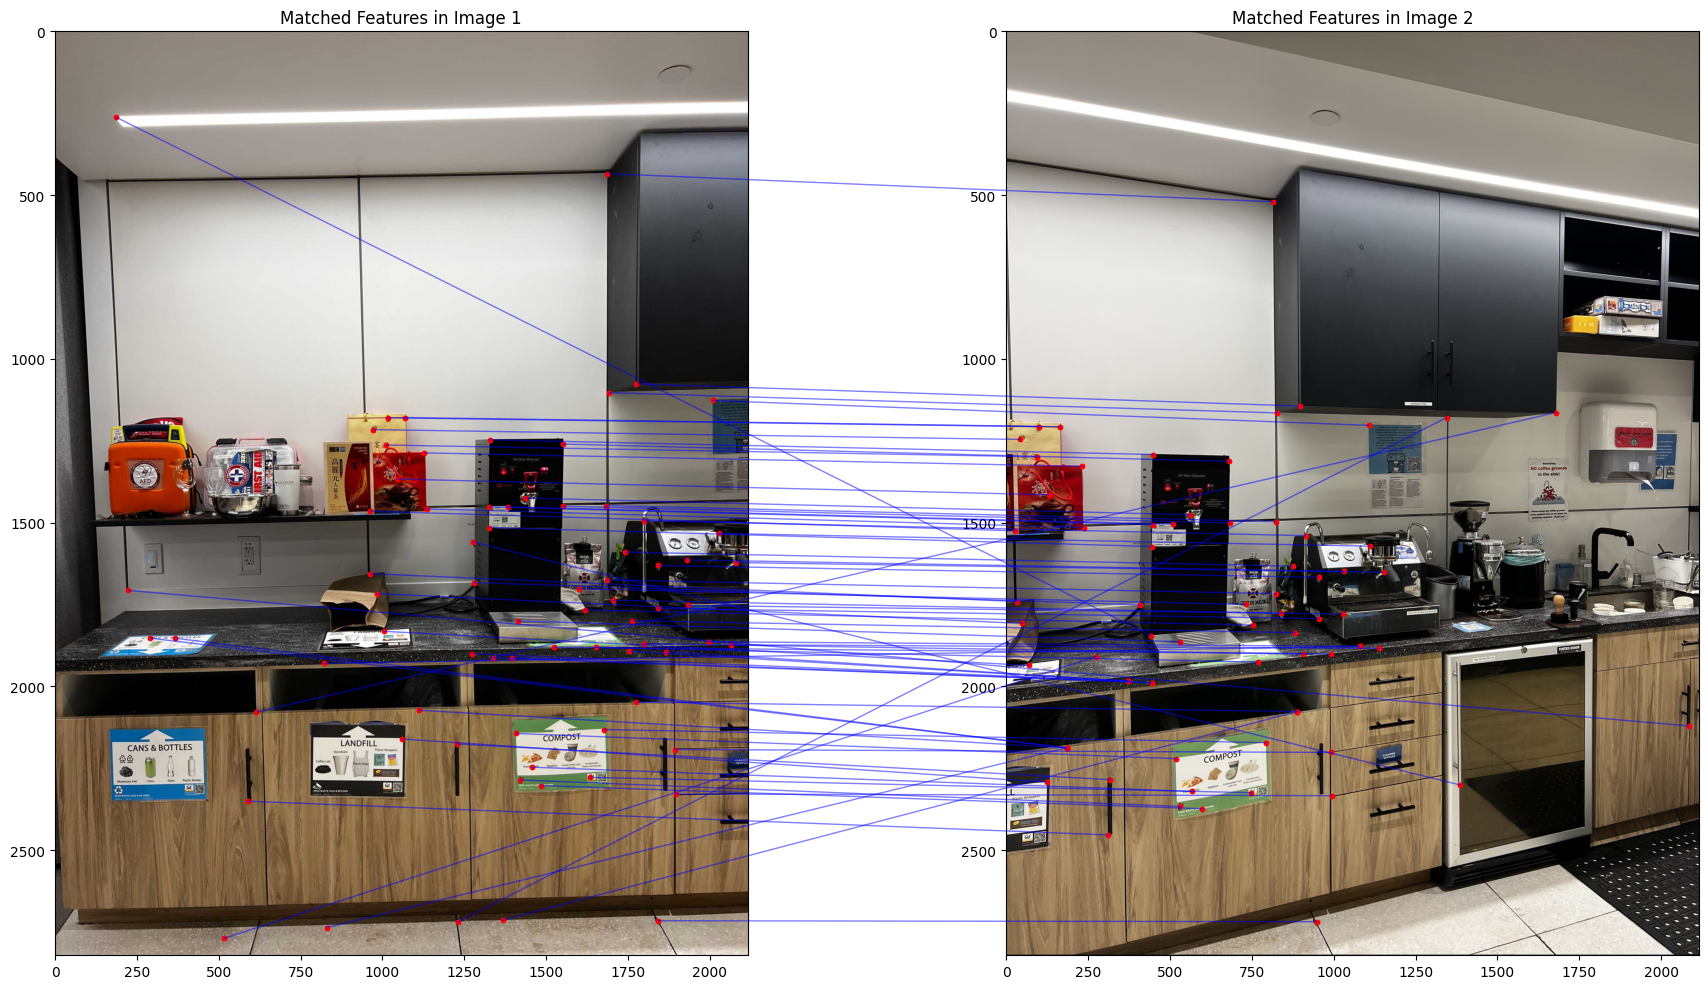

In [256]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(image)
ax2.imshow(image_2)

ax1.scatter(matched_coords_1[1], matched_coords_1[0], c='r', s=10)
ax2.scatter(matched_coords_2[1], matched_coords_2[0], c='r', s=10)

# Draw lines between corresponding points
for (y1, x1), (y2, x2) in zip(matched_coords_1.T, matched_coords_2.T):
    con = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA="data", coordsB="data",
                              axesA=ax1, axesB=ax2, color="blue", linewidth=1, alpha=0.5)
    fig.add_artist(con)

ax1.set_title('Matched Features in Image 1')
ax2.set_title('Matched Features in Image 2')

plt.tight_layout()
plt.savefig("./partb/matching_features.jpg", bbox_inches='tight') 
plt.show()

In [265]:
def ransac(matched_coords_1, matched_coords_2, reproj_thresh=5.0):
    pts1 = matched_coords_1.T.astype(np.float32)
    pts2 = matched_coords_2.T.astype(np.float32)

    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, reproj_thresh)
    matches_mask = mask.ravel().tolist()

    inlier_matches = []
    for i, m in enumerate(matches_mask):
        if m:
            inlier_matches.append((pts1[i], pts2[i]))

    return inlier_matches

In [266]:
ransac_matches = ransac(matched_coords_1, matched_coords_2)

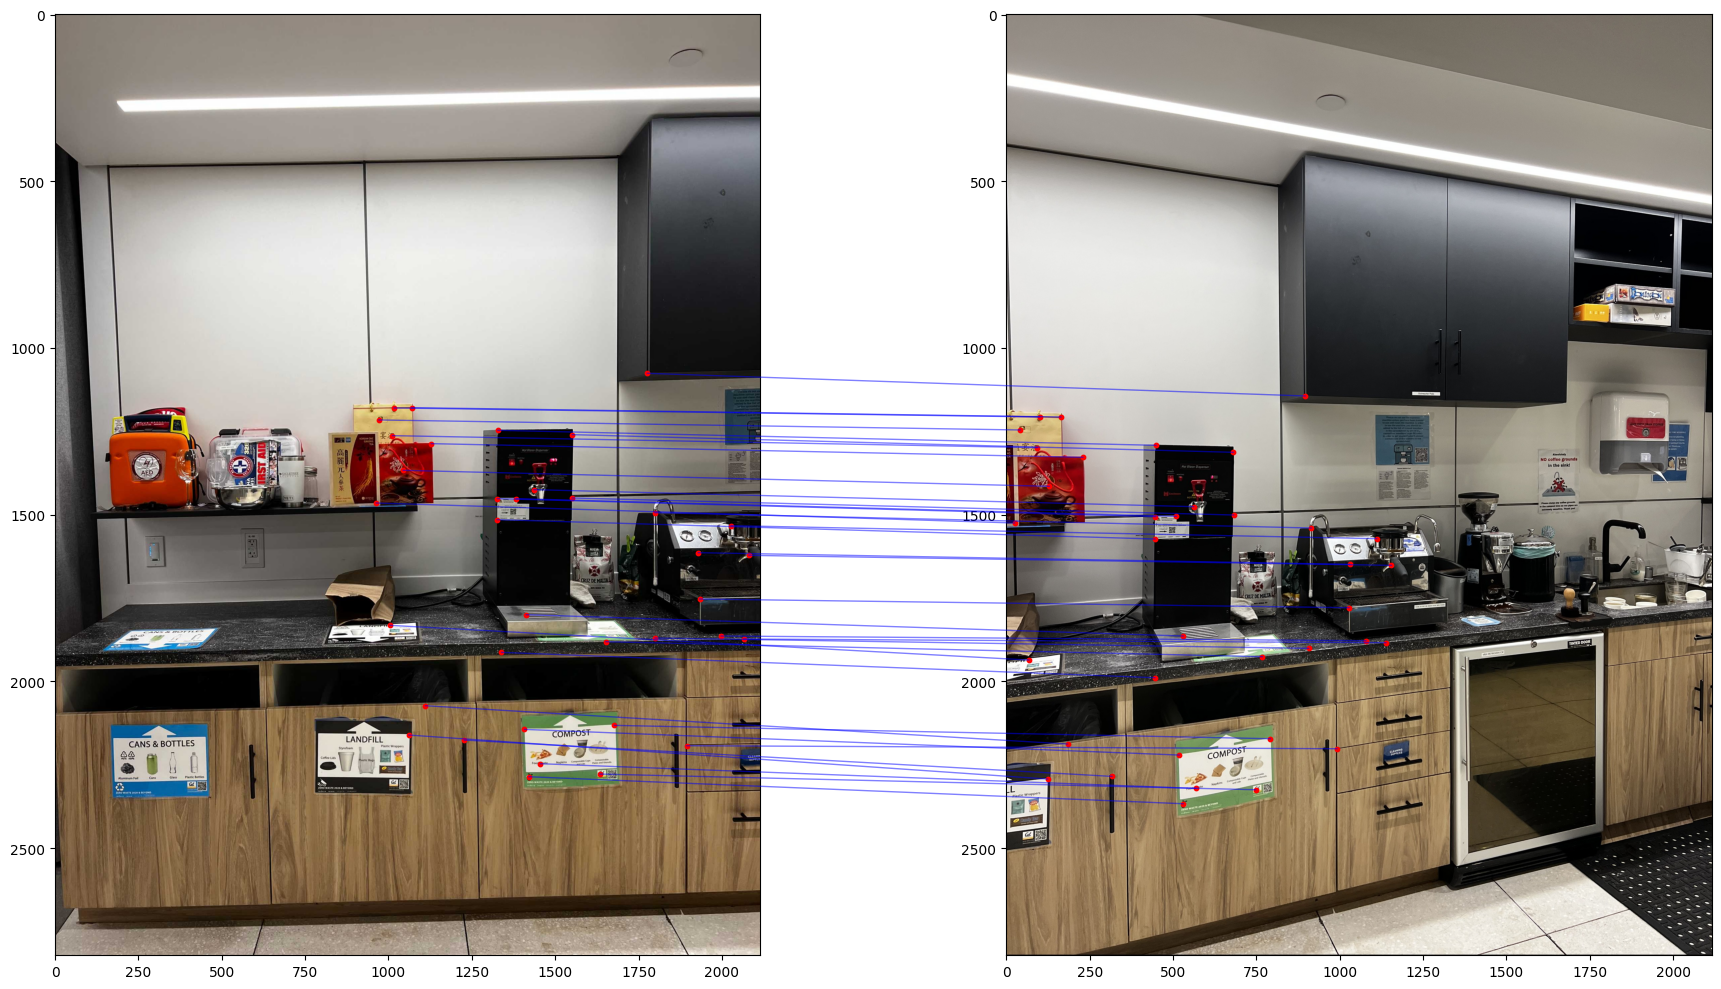

In [269]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image)
ax2.imshow(image_2)

for pt1, pt2 in ransac_matches:
    y1, x1 = pt1
    y2, x2 = pt2
    ax1.scatter(x1, y1, c='r', s=10)
    ax2.scatter(x2, y2, c='r', s=10)
    con = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="blue", linewidth=1, alpha=0.5)
    fig.add_artist(con)
plt.tight_layout()
plt.savefig("./partb/ransac_features.jpg", bbox_inches='tight') 
plt.show()